## Immorality

세 변수 ${X, Y, Z}$는 $Z$가 $X$와 $Y$의 직접적인 결과일 때 **비도덕 구조(immorality)** 를 형성한다. 연구자가 $Y$를 $X$의 함수로 모델링하려고 할 경우, $Z$는 **충돌부 변수(collider variable)** 라고 한다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

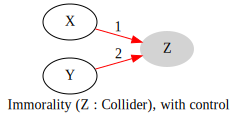

In [2]:
import graphviz as gr

immorality = gr.Digraph(
    'G',
    node_attr = {'shape': 'ellipse'}, 
    graph_attr = {
        'rankdir': 'LR',
        'label': 'Immorality (Z : Collider), with control'
    }
)

immorality.edge('X', 'Z', label = '1', color = 'red')
immorality.edge('Y', 'Z', label = '2', color = 'red')

immorality.node(
    'Z', style = 'filled', 
    fillcolor = 'lightgray', 
    shape = 'ellipse', 
    penwidth = '0'
)

immorality

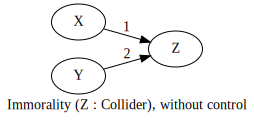

In [3]:
immorality = gr.Digraph(
    'G',
    node_attr = {'shape': 'ellipse'}, 
    graph_attr = {
        'rankdir': 'LR',
        'label': 'Immorality (Z : Collider), without control'
    }
)

immorality.edge('X', 'Z', label = '1')
immorality.edge('Y', 'Z', label = '2')

immorality

콜라이더는 계량경제학자들에게 특히 중요한데, $Z$의 효과를 통제하면 $X$가 $Y$에 미치는 효과 추정이 왜곡되기 때문이다. **확률 분포 $P$** 가 주어진 상황에서, 위 그림의 비도덕 구조(immorality)에 대해 베이지안 네트워크 분해를 적용하면 다음과 같은 식이 도출된다

$$
{\cal P}[X,Y,Z]={\cal P}[X]{\cal P}[Y]{\cal P}[Z|X,Y]
$$  

이 구조에서는 $X$와 $Y$ 사이에 연관성이 존재하지 않는다. 다음과 같이 확인할 수 있다.

$$
P[X,Y]=\sum_{Z}P[X]P[Y]P[Z|X,Y]=P[X]P[Y]\sum_{Z}P[Z|X,Y]=P[X]P[Y]
$$  

하지만 $Z$를 조건부화하면, 원래 $Z$가 차단하고 있던 $X$와 $Y$ 사이의 뒷문 경로 $(Y \rightarrow Z \leftarrow X)$가 열린다. 이를 설명하기 위해 다음과 같은 Data Generating Process(DGP)를 예로 든다

$$
\begin{array}{r l}&{X_{t}:=\epsilon_{t}}\\ &{}\\ &{Y_{t}:=\zeta_{t}}\\ &{}\\ &{Z_{t}:=X_{t}+Y_{t}+\xi_{t}}\end{array}
$$  

여기서 ${\xi_{t}, \epsilon_{t}, \zeta_{t}}$는 독립적인 표준 정규분포를 따르는 랜덤 변수이다. 이때, $X$와 $Y$ 사이의 공분산은 다음과 같다.

$$
\text{Cov}[X,Y]=E[(X-E[X])(Y-E[Y])]=E[X Y]=E[X]E[Y]=0
$$  

In [4]:
x = np.random.normal(size = 5000) # false cause
y = np.random.normal(size = x.shape[0]) # false effect
z = x + y + np.random.normal(size = x.shape[0]) # collider

문제는 연구자가 잘못된 방식으로 $Z$를 조건부화할 경우, $X$와 $Y$ 사이에 음의 공분산을 발견하게 된다는 점이다. 이는 $X$와 $Y$ 사이에 인과 경로가 없음에도 불구하고 다음과 같이 계산된다.

$$
\text{Cov}[X,Y|Z]=-\frac{1}{3}
$$  

이러한 상황은 Berkson의 오류로, 충돌부에 대해 조건부화하면서 서로 독립적인 두 변수 간의 비인과적 연관이 나타나는 경우다(Pearl, 2009). 인과 그래프(그림 16)는 기존의 혼란 변수(confounder) 구조(그림 13)와는 반대로, 충돌부로 바뀐다. 따라서 $Z$에 대해 조건부화하면 과도한 통제가 이루어지며, 이는 혼란 변수 문제와는 다른 문제를 야기한다.

이러한 상황은 계량경제학자들에게 문제가 되는데, 단순한 관찰 연구만으로는 인과 방향을 항상 명확히 규명할 수 없기 때문이다(Peters et al., 2017). 연구자들은 모델 명세에 적합한 인과 그래프를 제시하고 정당화해야 하며, 그렇지 않으면 동료들의 의심에 직면하게 된다.

이를 확인하기 위해, 위의 데이터 생성 과정으로부터 5,000개의 관측값을 추출한 후, 다음 선형 방정식을 적합시킨다.

$$
Y_{t}=\alpha+\beta X_{t}+\gamma Z_{t}+\varepsilon_{t}
$$  

In [5]:
import statsmodels.api as sm

# Incorrect estimate of X -> Y
X = np.column_stack((x, z))
ols0 = sm.OLS(
    y, sm.add_constant(X)
).fit()

In [6]:
print(ols0.summary(xname = ['const','X','Z'], yname = 'Y')) # false positive

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     2528.
Date:                Thu, 31 Oct 2024   Prob (F-statistic):               0.00
Time:                        00:53:23   Log-Likelihood:                -5398.5
No. Observations:                5000   AIC:                         1.080e+04
Df Residuals:                    4997   BIC:                         1.082e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0102      0.010     -1.014      0.3

충돌변수 $Z$에 의해 유도된 편향을 제거하려면 해당 변수를 추정 모형에서 제외하면 된다.

$$
Y_{t}=\alpha+\beta X_{t}+\varepsilon_{t}
$$  

In [7]:
# Correct estimate of X -> Y
ols1 = sm.OLS(
    y, sm.add_constant(x)
).fit()

In [8]:
print(ols1.summary(xname = ['const','X'], yname = 'Y')) # true negative

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.01628
Date:                Thu, 31 Oct 2024   Prob (F-statistic):              0.898
Time:                        00:53:24   Log-Likelihood:                -7146.1
No. Observations:                5000   AIC:                         1.430e+04
Df Residuals:                    4998   BIC:                         1.431e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0099      0.014     -0.690      0.4

아래의 그림은 이러한 조정의 결과를 보여준다. 잘못된 모델 명세는 더 높은 설명력을 제공했기 때문에, specification searching을 수행했을 경우 연구자는 **false positive** 에 속을 수 있었다. 하지만 올바른 모형에서는 연구자가 $X$가 $Y$를 유발하지 않는다는 결론에 도달하게 된다.

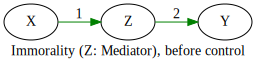

In [9]:
mediator = gr.Digraph(
    'G',
    node_attr = {'shape': 'ellipse'}, 
    graph_attr = {
        'rankdir': 'LR', 
        'label': 'Immorality (Z: Mediator), before control'
    }
)

mediator.edge('X', 'Z', label = '1', color = 'green')
mediator.edge('Z', 'Y', label = '2', color = 'green')

mediator

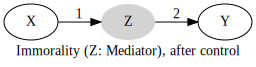

In [10]:
mediator = gr.Digraph(
    'G',
    node_attr = {'shape': 'ellipse'}, 
    graph_attr = {
        'rankdir': 'LR', 
        'label': 'Immorality (Z: Mediator), after control'
    }
)

mediator.edge('X', 'Z', label = '1')
mediator.edge('Z', 'Y', label = '2')

mediator.node(
    'Z', style = 'filled', 
    fillcolor = 'lightgray', 
    shape = 'ellipse', 
    penwidth = '0'
)

mediator